Before starting, you will need to install some packages to reproduce the baseline.

In [1]:
from pathlib import Path
import os

import copy

import wandb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import numpy as np
import pandas as pd


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

## Data loading

In [2]:
# put your own path to the data root directory (see example in `Data architecture` section)
data_dir = Path("data/")

# load the training and testing data sets
train_features_dir = data_dir / "train_input" / "moco_features"
test_features_dir = data_dir / "test_input" / "moco_features"
df_train_val = pd.read_csv(data_dir  / "supplementary_data" / "train_metadata.csv")
df_test = pd.read_csv(data_dir  / "supplementary_data" / "test_metadata.csv")

# concatenate y_train_val and df_train_val
y_train_val = pd.read_csv(data_dir  / "train_output.csv")
df_train_val = df_train_val.merge(y_train_val, on="Sample ID")

print(f"Training data dimensions: {df_train_val.shape}")  # (344, 4)
df_train_val.head()

Training data dimensions: (344, 4)


,Sample ID,Patient ID,Center ID,Target
0,ID_001.npy,P_001,C_1,0
1,ID_002.npy,P_002,C_2,1
2,ID_005.npy,P_005,C_5,0
3,ID_006.npy,P_006,C_5,0
4,ID_007.npy,P_007,C_2,1


## Data processing

We now load the features matrices $\mathbf{K_s} \in \mathbb{R}^{(1000,\,2048)}$ for $s=1,...,344$ and perform slide-level averaging. This operation should take at most 5 minutes on your laptop.

In [3]:
X_train_val = []
X_train_val_all = []
y_train_val = []

centers_train_val = []
patients_train_val = []

for sample, label, center, patient in tqdm(
    df_train_val[["Sample ID", "Target", "Center ID", "Patient ID"]].values
):
    # load the coordinates and features (1000, 3+2048)
    _features = np.load(train_features_dir / sample)
    # get coordinates (zoom level, tile x-coord on the slide, tile y-coord on the slide)
    # and the MoCo V2 features
    coordinates, features = _features[:, :3], _features[:, 3:]  # Ks
    # slide-level averaging
    X_train_val.append(np.mean(features, axis=0))
    X_train_val_all.append(features)
    y_train_val.append(label)

    centers_train_val.append(center)
    patients_train_val.append(patient)

# convert to numpy arrays
X_train_val = np.array(X_train_val)
X_train_val_all = np.array(X_train_val_all)
y_train_val = np.array(y_train_val)

centers_train_val = np.array(centers_train_val)
patients_train_val = np.array(patients_train_val)

100%|██████████| 344/344 [00:03<00:00, 109.30it/s]


In [4]:
patients_unique = np.unique(patients_train_val)
y_unique = np.array(
    [np.mean(y_train_val[patients_train_val == p]) for p in patients_unique]
)

print(
    "Training set specifications\n"
    "---------------------------\n"
    f"{len(X_train_val)} unique samples\n"
    f"{len(patients_unique)} unique patients\n"
)

Training set specifications
---------------------------
344 unique samples
305 unique patients



In [5]:
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
# split is performed at the patient-level
for train_idx_, val_idx_ in kfold.split(patients_unique, y_unique):
    # retrieve the indexes of the samples corresponding to the
    # patients in `train_idx_` and `val_idx_`
    train_idx = np.arange(len(X_train_val))[
        pd.Series(patients_train_val).isin(patients_unique[train_idx_])
    ]
    val_idx = np.arange(len(X_train_val))[
        pd.Series(patients_train_val).isin(patients_unique[val_idx_])
    ]
    # set the training and validation folds
    X_train = X_train_val[train_idx]
    X_val = X_train_val[val_idx]

    X_train_all = X_train_val_all[train_idx]
    X_val_all = X_train_val_all[val_idx]

    y_train = y_train_val[train_idx]
    y_val = y_train_val[val_idx]
    break

## Model definition

In [6]:
class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self, num_layers=1, inside_dim=0):
    super().__init__()
    self.inside_dim = inside_dim
    self.num_layers = num_layers
    self.name = f"MLP/num_layers_{num_layers}_inside_dim_{inside_dim}"
    self.model_type = "MLP"
    self.best_path = None
    
    if num_layers==1:
      self.layers = nn.Sequential(
        nn.Linear(2048, 1),
        nn.Sigmoid(),
        )

    else:
      list_layers = [nn.Linear(2048, inside_dim),nn.Dropout(p=0.2), nn.ReLU()]
      for _ in range(num_layers-2):
        list_layers.append(nn.Linear(inside_dim, inside_dim))
        list_layers.append(nn.Dropout(p=0.2))
        list_layers.append(nn.ReLU())
      list_layers.append(nn.Linear(inside_dim, 1))
      list_layers.append(nn.Sigmoid())
      self.layers = nn.Sequential(*list_layers)


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [7]:
class MaxModel(nn.Module):
  def __init__(self, model):
    super().__init__()
    self.model = copy.deepcopy(model)
    self.name = f"MaxModel/{model.name}"
    self.model_type = f"MaxModel/{model.model_type}"
    self.best_path = None

  def forward(self, x):
    '''Forward pass on the 1000 features'''
    model_predictions = self.model(x)
    max_prediction, _ = model_predictions.max(axis=-2)
    return max_prediction

In [8]:
class SmoothMaxModel(nn.Module):
  def __init__(self, model):
    super().__init__()
    self.model = copy.deepcopy(model)
    self.name = f"SmoothMaxModel/{model.name}"
    self.model_type = f"SmoothMaxModel/{model.model_type}"
    self.best_path = None

  def forward(self, x):
    '''Forward pass on the 1000 features'''
    model_predictions = self.model(x)
    max_prediction = (torch.log(torch.exp(model_predictions).sum(axis=-2)) / model_predictions.shape[-2])
    return max_prediction

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
class RocLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_predict, y):
        y_predict_pos = y_predict[y == 1]
        y_predict_neg = y_predict[y == 0]

        return ((1 - y_predict_pos.unsqueeze(dim=0) + y_predict_neg.unsqueeze(dim=1)).clamp_min(0)).mean()

In [11]:
def train(X_train, y_train, X_val, y_val, model, lr=1e-6, batch_size=64, nb_epochs=5000, criterion=nn.BCELoss(), use_wandb=False, exp_name=None):
    train_set = CustomDataset(X_train, y_train)
    train_dataloader = DataLoader(train_set, batch_size=batch_size,  drop_last=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    try:
        if use_wandb:
            if model.model_type == "MLP":
                config = {
                    "learning_rate": lr,
                    "batch_size": batch_size,
                    "inside_dim": model.inside_dim,
                    "num_layers": model.num_layers
                    }
            elif model.model_type in ["MaxModel/MLP", "SmoothMaxModel/MLP"]:
                config = {
                    "learning_rate": lr,
                    "batch_size": batch_size,
                    "inside_dim": model.model.inside_dim,
                    "num_layers": model.model.num_layers
                    }
            
            run_name = f"{model.name}/{criterion._get_name()}/lr_{'{:.0e}'.format(lr)}/bs_{batch_size}"
            if exp_name is not None:
                wandb.init(project="OWKIN", name=f"{exp_name}/{run_name}", config=config)
            else :
                wandb.init(project="OWKIN", name=run_name, config=config)

        best_val_roc_auc_score = 0
        best_epoch = 0
        best_state_dict = copy.deepcopy(model.state_dict())

        for epoch in range(1, nb_epochs+1):
            model.train()
            train_losses = []
            for x, y in train_dataloader:
                y_predict = model(x.to("cuda"))
                loss = criterion(y_predict.cpu(), y.unsqueeze(dim=1).float())
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())
            train_loss = np.array(train_losses).mean()

            model.eval()
            train_roc_auc_score = roc_auc_score(y_train, model(torch.Tensor(X_train).cuda()).cpu().detach())
            val_roc_auc_score = roc_auc_score(y_val, model(torch.Tensor(X_val).cuda()).cpu().detach())

            if val_roc_auc_score > best_val_roc_auc_score:
                best_val_roc_auc_score = val_roc_auc_score
                best_epoch = epoch
                best_state_dict = copy.deepcopy(model.state_dict())

            if use_wandb:
                to_log = {}
                to_log["main/train_loss"] = train_loss
                to_log["main/train_roc_auc_score"] = train_roc_auc_score
                to_log["main/val_roc_auc_score"] = val_roc_auc_score
                wandb.log(to_log)

            elif epoch % (nb_epochs//10) == 0:
                print(f"epoch {epoch}: loss={'{:.3f}'.format(train_loss)}, train_roc_auc_score={'{:.3f}'.format(train_roc_auc_score)}, val_auc_roc_auc_score={'{:.3f}'.format(val_roc_auc_score)}")

    except KeyboardInterrupt:
        pass

    if use_wandb:
        wandb.finish()
    PATH_DIR = Path(f"models/{model.name}")
    PATH = PATH_DIR / f"best_epoch_{best_epoch}_score_{'{:.3f}'.format(best_val_roc_auc_score)}.pt"

    model.best_path = PATH

    if not PATH_DIR.is_dir():
        os.makedirs(PATH_DIR)

    torch.save(best_state_dict, PATH)

## Trainings

### MLP

In [12]:
num_layers = 2
inside_dim = 512
model = MLP(num_layers=num_layers, inside_dim=inside_dim)
model.cuda()

lr=1e-5
batch_size = 64
nb_epochs = 2000

In [13]:
train(X_train, y_train, X_val, y_val, model, lr=lr, batch_size=batch_size, nb_epochs=nb_epochs, use_wandb=False)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: stanislasdozias. Use `wandb login --relogin` to force relogin


main/train_loss,██▇▆▆▆▅▅▅▄▄▄▃▃▃▃▄▃▃▃▄▃▂▂▂▄▂▂▄▂▃▃▂▃▁▃▁▃▁▂
main/train_roc_auc_score,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇████████████████████████
main/val_roc_auc_score,▁▃▆██▇█████▇▇███▇████████████████████▇▇█
main/train_loss,0.18069
main/train_roc_auc_score,0.9697
main/val_roc_auc_score,0.72628


In [14]:
if model.best_path is None:
    best_val_score = 0
    best_path = None
    for model_path in Path(f"models/{model.name}").glob("*"):
        val_score = float(model_path.name[-8:-3])
        if val_score > best_val_score:
            best_path = model_path
            best_val_score = val_score
    model.best_path = best_path
else:
    print("model got already a best path:")
    
print(f"best path: {model.best_path}")

model.load_state_dict(torch.load(model.best_path))
model.eval()

print(f"val score: {roc_auc_score(y_val, model(torch.Tensor(X_val).cuda()).cpu().detach())}")

model got already a best path:
best path: models\MLP\num_layers_2_inside_dim_512\best_epoch_1117_score_0.738.pt
val score: 0.7381422924901186


### MaxModel/MLP

In [15]:
max_model = MaxModel(model)
max_model.cuda()

lr = 1e-5
batch_size = 16
nb_epochs = 4000

In [16]:
train(X_train_all, y_train, X_val_all, y_val, max_model, lr=lr, batch_size=batch_size, nb_epochs=nb_epochs, use_wandb=True)

In [ ]:
if max_model.best_path is None:
    best_val_score = 0
    best_path = None
    for model_path in Path(f"models/{max_model.name}").glob("*"):
        val_score = float(model_path.name[-8:-3])
        if val_score > best_val_score:
            best_path = model_path
            best_val_score = val_score
    max_model.best_path = best_path
else:
    print("model got already a best path:")

print(f"best path: {max_model.best_path}")

max_model.load_state_dict(torch.load(max_model.best_path))
max_model.eval()

print(f"val score: {roc_auc_score(y_val, max_model(torch.Tensor(X_val_all).cuda()).cpu().detach())}")

model got already a best path:
best path: models\MaxModel\MLP\num_layers_2_inside_dim_512\best_epoch_38_score_0.628.pt
val score: 0.6284584980237155


### SmoothMaxModel/MLP

In [ ]:
smooth_max_model = SmoothMaxModel(model)
smooth_max_model.cuda()

lr = 1e-5
batch_size = 16
nb_epochs = 4000

In [ ]:
train(X_train_all, y_train, X_val_all, y_val, smooth_max_model, lr=lr, batch_size=batch_size, nb_epochs=nb_epochs, use_wandb=True)

main/train_loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
main/train_roc_auc_score,▁▃▄▅▆▆▇▇▇███████████████████████████████
main/val_roc_auc_score,▁█▆█▇█████▇▇▆▆▆▆▅▅▅▅▅▆▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄
main/train_loss,0.99914
main/train_roc_auc_score,1.0
main/val_roc_auc_score,0.56423


In [ ]:
if smooth_max_model.best_path is None:
    best_val_score = 0
    best_path = None
    for model_path in Path(f"models/{smooth_max_model.name}").glob("*"):
        val_score = float(model_path.name[-8:-3])
        if val_score > best_val_score:
            best_path = model_path
            best_val_score = val_score
    smooth_max_model.best_path = best_path
else:
    print("model got already a best path:")

print(f"best path: {smooth_max_model.best_path}")

smooth_max_model.load_state_dict(torch.load(smooth_max_model.best_path))
smooth_max_model.eval()

print(f"val score: {roc_auc_score(y_val, smooth_max_model(torch.Tensor(X_val_all).cuda()).cpu().detach())}")

model got already a best path:
best path: models\SmoothMaxModel\MLP\num_layers_2_inside_dim_512\best_epoch_1_score_0.732.pt
val score: 0.7322134387351779


## Analysis

In [ ]:
# trainings finished, we put all on cpu
model.cpu()
model.eval()

max_model.cpu()
max_model.eval()

smooth_max_model.cpu()
smooth_max_model.eval()
pass

In [ ]:
val_predictions = model(torch.Tensor(X_val)).detach().cpu()

val_max_preditions = max_model(torch.Tensor(X_val_all)).detach().cpu()

val_smooth_max_preditions = smooth_max_model(torch.Tensor(X_val_all)).detach().cpu()

### ROC Curve

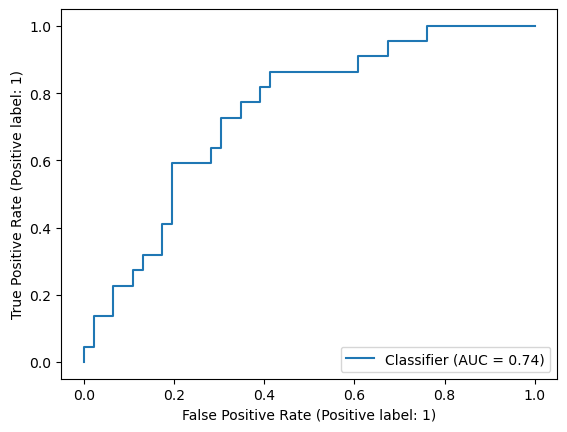

In [ ]:
# Predictions of model
RocCurveDisplay.from_predictions(y_val, val_predictions)

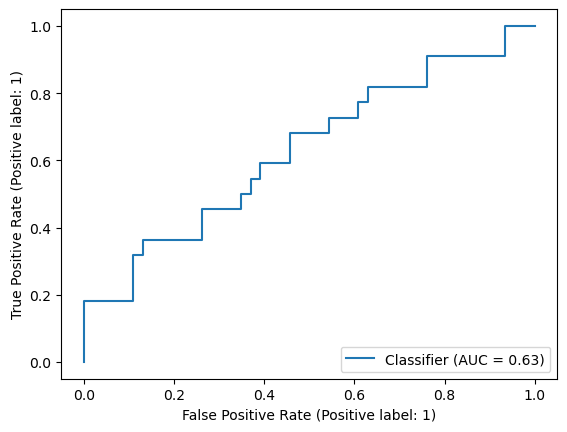

In [ ]:
# Predictions of max model
RocCurveDisplay.from_predictions(y_val, val_max_preditions)

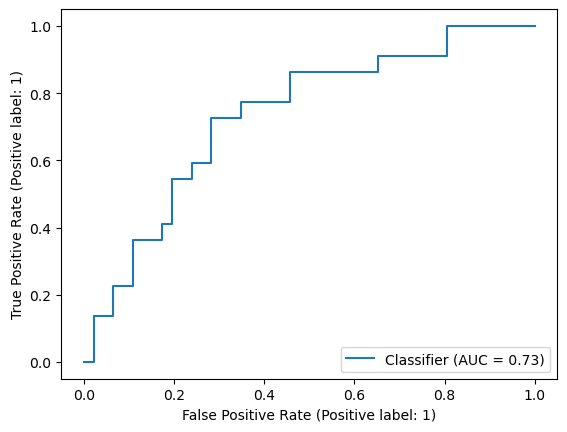

In [ ]:
# Predictions of smooth max model
RocCurveDisplay.from_predictions(y_val, val_smooth_max_preditions)

## Repartitions

In [ ]:
X_positive_train = X_train_all[y_train == 1]
X_negative_train = X_train_all[y_train == 0]

In [ ]:
all_positive_features = torch.Tensor(X_positive_train)
all_negative_features = torch.Tensor(X_negative_train)

all_positive_predict = max_model(all_positive_features).flatten()
all_negative_predict = max_model(all_negative_features).flatten()

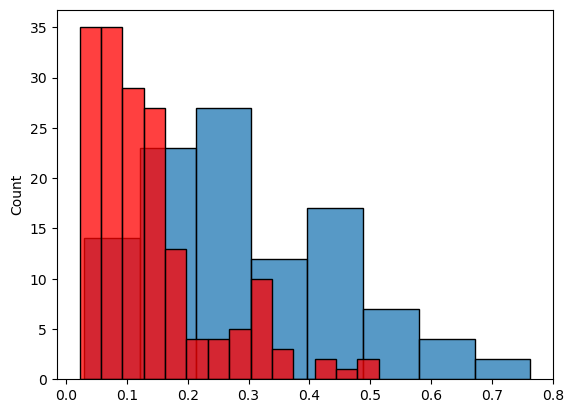

In [ ]:
sns.histplot(all_positive_predict.detach(), label="positive")
sns.histplot(all_negative_predict.detach(), label="negative", color="r")
plt.legend()
plt.show()

In [ ]:
raise ValueError

ValueError: 

## Inference for submission

In [ ]:
submit_model = max_model

In [ ]:
X_test = []
X_test_all = []

# load the data from `df_test` (~ 1 minute)
for sample in tqdm(df_test["Sample ID"].values):
    _features = np.load(test_features_dir / sample)
    coordinates, features = _features[:, :3], _features[:, 3:]
    X_test.append(np.mean(features, axis=0))
    X_test_all.append(features)

X_test = np.array(X_test)
X_test_all = np.array(X_test_all)

100%|██████████| 149/149 [00:01<00:00, 108.26it/s]


In [ ]:
if submit_model.model_type == model.model_type:
    y_test = submit_model(torch.Tensor(X_test).cuda()).cpu().detach().squeeze().numpy()
if submit_model.model_type == max_model.model_type:
    y_test = submit_model(torch.Tensor(X_test_all)).cpu().detach().squeeze().numpy()

In [ ]:
submission = pd.DataFrame(
    {"Sample ID": df_test["Sample ID"].values, "Target": y_test}
).sort_values(
    "Sample ID"
)  # extra step to sort the sample IDs

# sanity checks
assert all(submission["Target"].between(0, 1)), "`Target` values must be in [0, 1]"
assert submission.shape == (149, 2), "Your submission file must be of shape (149, 2)"
assert list(submission.columns) == [
    "Sample ID",
    "Target",
], "Your submission file must have columns `Sample ID` and `Target`"

# save the submission as a csv file
submission.to_csv(data_dir / f"test_outputs/{submit_model.name}.csv", index=None)
submission.head()

,Sample ID,Target
0,ID_003.npy,0.123896
1,ID_004.npy,0.172772
2,ID_008.npy,0.149632
3,ID_009.npy,0.094844
4,ID_010.npy,0.093628
